In [3]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from utils.embedding_utils import *
from utils.classifier_utils import *
# from classifiers.CustomClassifiers import AggregateClassifier,AggregateClassifierGrid
from itertools import combinations

imported utils


In [4]:
!pip install gensim
!pip install seaborn
!pip install statsmodels
!pip install optuna

In [5]:
embedding_dir=os.path.join(os.getcwd(),'outputs',"stats","main_54")
full_stat_df=pd.read_csv(os.path.join(embedding_dir,"embedding_stats_avg5.csv"))
output_dir=os.path.join(embedding_dir,"stat_analysis")

In [6]:
def run_embedding_classiciation(stat_df,X_weight,use_prob=True,min_combos=3,
                                max_combos=4,skip_w=True,pred_col='diagnosis',conditionals=[],data_names=['W','rad','btw','coh']):
    graph_labels = stat_df[pred_col].values
#     data_names=['rad','btw','coh']
    features=[]
    for n in data_names:
        if n in ['rad','btw','coh']:
            cols_to_use=[c for c in stat_df.columns if n in c.lower()]
            if use_prob:
                cols_to_use=[c for c in cols_to_use if 'prob' in c.lower()]
            else:
                cols_to_use=[c for c in cols_to_use if 'prob' not in c.lower()]
            n_df=np.array(stat_df[cols_to_use])
            data,y_comb,pat_to_indx=combine_patient_feats(n_df,graph_labels,stat_df,conditional=conditionals)
            print(n_df,'NF')
        else:
            n_df=X_weight
            data,y_comb,pat_to_indx=combine_patient_feats(n_df,graph_labels,stat_df,conditional=conditionals)
            Wa=data
            
            
#         data,y_comb,pat_to_indx=combine_patient_feats(n_df,graph_labels,stat_df,conditional=conditionals)
        features.append(data)
        
    
        

#     Wa=X_weight_comb
#     names=['W','X_rc','X_bc','X_wc']
    indices=np.array([i for i in range(len(data_names))])
    feature_combinations=[]
    name_combinations=[]
    list_combinations = list()

    for n in range(min_combos,max_combos+1):
        for combo in combinations(indices, n):
            print(combo)
            feat_list=[features[i] for i in combo]
            name_list=[data_names[i] for i in combo]
            print(name_list)
            feat_combines=np.hstack(feat_list)
            print(feat_combines.shape)
            feature_combinations.append(feat_combines)
            name_combinations.append(name_list)

    if not skip_w:
        feature_combinations=[Wa]+feature_combinations
        name_combinations=[['W']]+name_combinations
        
    return feature_combinations,name_combinations,y_comb
    

In [7]:
conditionals = ((full_stat_df['CogTr']==1))
fit_method='concatenate'
predict_method='same'
# run_combos_list(model_type=LogisticRegression,names=name_combinations,
#                 feature_list=feature_combinations,times=1,
#                 use_agg=True,agg_fit=fit_method,agg_pred=predict_method,y_comb=y_comb)  


In [8]:
import argparse
parser = argparse.ArgumentParser(description='RiemannianGNN')
args, _ = parser.parse_known_args()
MEGLpParams.add_params(parser)
args = parser.parse_args(args=[])

In [9]:
BAND_TO_INDEX = {'theta':0,'alpha':1,'beta1':2,'beta2':3,'beta':4,'gamma':5}
METRIC_TO_INDEX = {'plv':0,'ciplv':1}


band_adj = BAND_TO_INDEX['alpha']
metric_adj = METRIC_TO_INDEX[args.metric]
raw_scans = np.load(args.raw_scan_file)
scan_data = raw_scans[:,band_adj,metric_adj] ### this is not changed by any hyperparamters

graph_ids = full_stat_df['Scan Index'].values
scan_data = raw_scans[:,band_adj,metric_adj] ### this is not changed by any hyperparamters
train_scans = scan_data[graph_ids.astype(int) ]
X_weight = np.array([a[np.triu_indices(a.shape[0])] for a in train_scans])

In [10]:

feature_combinations,name_combinations,y_comb=run_embedding_classiciation(full_stat_df,X_weight,skip_w=True,
                                                use_prob=False,min_combos=1,max_combos=2,conditionals=conditionals,data_names=['W','rad'])

conditational
0       True
1       True
2       True
3       True
4       True
       ...  
175    False
176    False
177    False
178    False
179    False
Name: CogTr, Length: 180, dtype: bool
NO SHUFFLE
conditational
0       True
1       True
2       True
3       True
4       True
       ...  
175    False
176    False
177    False
178    False
179    False
Name: CogTr, Length: 180, dtype: bool
NO SHUFFLE
[[1.14856664 2.0953061  2.18031072 ... 2.05160935 1.42537626 2.26457091]
 [1.12309426 2.06000353 2.21085388 ... 2.09441905 1.45372466 2.33475558]
 [1.21732124 1.98617806 2.04157465 ... 1.89624364 1.33290461 1.99036129]
 ...
 [1.19672428 2.10935528 2.21695379 ... 2.04229307 1.52801455 2.00044454]
 [1.30283475 1.89239307 1.91787272 ... 1.98593059 1.42585129 1.99628657]
 [1.29968796 1.78858962 1.84196672 ... 1.9000061  1.39210995 1.90546139]] NF
(0,)
['W']
(46, 4095, 2)
(1,)
['rad']
(46, 8, 2)
(0, 1)
['W', 'rad']
(46, 4103, 2)


In [16]:
fit_method='use_second'
predict_method='same'
np.random.seed(27)
names,f1_means,roc_means = run_combos_list(model_type=SVC,names=name_combinations,
                feature_list=feature_combinations,times=50,
                use_agg=True,agg_fit=fit_method,
                agg_pred=predict_method,y_comb=y_comb,use_nested=False)  
# run_combos_list(model_type=SVC,names=name_combinations,
#                 feature_list=feature_combinations,times=1,
#                 use_agg=True,agg_fit=fit_method,
#                 agg_pred=predict_method,y_comb=y_comb,use_nested=False)  

NameError: name 'sksks' is not defined

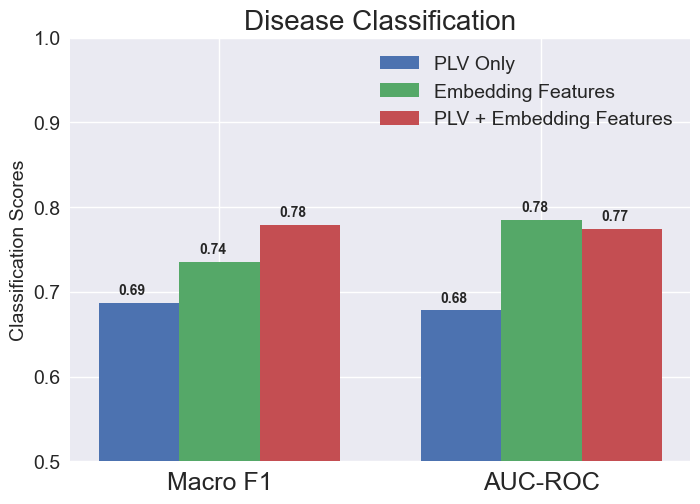

In [14]:
start=0
ax = plt.gca()

class_scores_raw=np.array([f1_means[0], roc_means[0]])[start:]
# class_scores_raw=np.array([.651, .73])[start:]
class_scores_emb=np.array([f1_means[1], roc_means[1]])[start:]
class_scores_comb=np.array([f1_means[2], roc_means[2]])[start:]
# class_scores_comb=np.array([.737, .823])[start:]

X = ['Macro F1', 'AUC-ROC'][start:]
plt.style.use('default')
plt.style.use('seaborn')

# ax.set_facecolor("white")
  
X_axis = np.arange(len(X))*.8
  
plt.bar(X_axis - 0.2,  class_scores_raw, 0.2, label = 'PLV Only')
plt.bar(X_axis - 0, class_scores_emb, 0.2, label = 'Embedding Features')
plt.bar(X_axis +.2,  class_scores_comb, 0.2, label = 'PLV + Embedding Features')
decimals = 2

for i in range(len(class_scores_raw)):
    x_i=X_axis[i]
    score=class_scores_raw[i]
    plt.text(x_i-.25, score+0.01, str(np.round(score, decimals)), fontweight='bold')
for i, score in enumerate(class_scores_emb):
    x_i=X_axis[i]
    score=class_scores_emb[i]
    plt.text(x_i-.05, score+0.01, str(np.round(score, decimals)), fontweight='bold')
for i, score in enumerate(class_scores_comb):
    x_i=X_axis[i]
    score=class_scores_comb[i]
    plt.text(x_i+.15, score+0.01, str(np.round(score, decimals)), fontweight='bold')
    
# plt.text(.47, roc_scores_rawstack[0]+0.01, str(np.round( roc_scores_rawstack[0], 2)), fontweight='bold')
    
# plt.text(0,)
plt.xticks(X_axis, X,fontsize=18)
plt.yticks(fontsize=14)
# plt.xlabel("# Dimensions")
plt.ylabel("Classification Scores",fontsize=14)
plt.title("Disease Classification", fontsize=20)
ax = plt.gca()
ax.set_ylim(ymin=.5,ymax=1)
plt.legend(fontsize=14)
plot_save_dir = r'C:\Users\Cole Baker\OneDrive - 1910 Genetics\Desktop\misc\hyperBrain\outputs\stats\main_54'
plt.savefig(os.path.join(plot_save_dir,'classification_score_'+str(decimals)))
plt.show()